# 2-Link Arm
Implementation of a 2-link arm.

![title](img/2-link-robotic-arm.png)

$q = \left[\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2\right] \rightarrow \dot{q} = \left[q_3, q_4, \ddot{q}_1, \ddot{q}_2\right]$

ODE is defined as:

$\ddot{q} = B^{-1}(q)(-C(\dot{q}, q) - g(q) + F)$

With:

$B(q) = \begin{bmatrix}
    (m_1 + m_2)l_1^2 + m_2l_2^2 + 2m_2l_1l_2\cos(q_2) & m_2l_2^2 + m_2l_1l_2\cos(q_2) \\
    m_2l_2^2 + m_2l_1l_2\cos(q_2) & m_2l_2^2 
    \end{bmatrix}\\
C(\dot{q}, q) = \begin{bmatrix}
    -m_2l_1l_2\sin(q_2)(2q_3q_4 + q_4^2) \\
    -m_2l_1l_2\sin(q_2)q_3q_4
    \end{bmatrix}\\
g(q) = \begin{bmatrix}
    -(m_1+m_2)gl_1\sin(q_1) - m_2gl_2\sin(q_1+q_2) \\
    -m_2gl_2\sin(q_1+q_2)
    \end{bmatrix}$

In [1]:
import numpy as np
from scipy.integrate import ode

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

# %pylab inline
# import pylab as plt
# plt.rcParams['figure.figsize'] = (15, 6)

## Equations of motion

In [31]:
def eom(t, q, u, params, ths=None, Kpd=None):
    m1 , m2, l1, l2, g = params
    q1, q2, q3, q4, q5, q6 = q

    b11 = (m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*np.cos(q2)
    b12 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b21 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b22 = m2*l2**2
    B = np.array([[b11, b12], [b21, b22]])

    c1 = -m2*l1*l2*np.sin(q2)*(2*q3*q4 + q4**2)
    c2 = -m2*l1*l2*np.sin(q2)*q3*q4
    C = np.array([[c1], [c2]])
    
    g1 = -(m1 + m2)*g*l1*np.sin(q1) - m2*g*l2*np.sin(q1 + q2)
    g2 = -m2*g*l2*np.sin(q1 + q2)
    g = np.array([[g1], [g2]])
    
    if u is not None:
        print(u)
        F = u
    else:
        Kp1, Kd1, Ki1, Kp2, Kd2, Ki2 = Kpd        
        th1s, th2s = ths

        f1 = Kp1*(th1s - q1) - Kd1*q3 + Ki1*q5
        f2 = Kp2*(th2s - q2) - Kd2*q4 + Ki2*q6
        
        Fhat = np.array([[f1], [f2]])
        
        F = np.dot(B, Fhat)
        
    qdotdot = np.dot(np.linalg.inv(B), -C - g + F)
    
    qdot = [q3, q4] + qdotdot.T[0].tolist()
    
    if u is None:
        qdot += [th1s-q1, th2s-q2]
        
    print(qdot)
        
    return qdot

## Solver
Solve system with with initial position $q_0 = \left[\pi/2, \pi/2, 0., 0.\right]$ and desired position $\theta_s = \left[\pi/2, -\pi/2\right]$. Parameters are set to $m_1 = m_2 = l_1 = l_2 = 1$ and $g = 9.81$.

Solve with simple PID controller, with $K_p = \left[15, 15\right]$ and $K_d = \left[7, 10\right]$ and $K_i = \left[10, 10\right]$.

In [24]:
q0 = [-np.pi/2, np.pi/2, 0., 0., 0., 0.]
ths = (np.pi/2, -np.pi/2)
Ts = 20

m1 = 1
m2 = 1
l1 = 1
l2 = 1
g = 9.81
params = (m1, m2, l1, l2, g)

Kp1 = 15
Kd1 = 7
Ki1 = 10
Kp2 = 15
Kd2 = 10
Ki2 = 10
Kpd = (Kp1, Kd1, Ki1, Kp2, Kd2, Ki2)

r = ode(eom).set_integrator('dopri5')
r.set_initial_value(q0, 0).set_f_params(None, params, ths, Kpd)
dt = 0.1
sol = []
while r.successful() and r.t < Ts:
    sol.append(r.integrate(r.t + dt))
    
sol = np.array(sol)

## Results

<IPython.core.display.Javascript object>


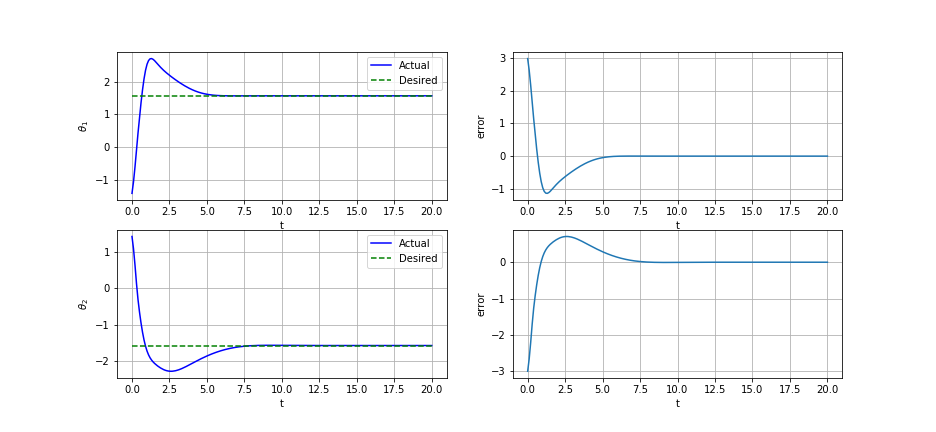

In [19]:
t = np.linspace(0, Ts, Ts*10)

q1d = np.ones(len(t))*ths[0]
q2d = np.ones(len(t))*ths[1]

%matplotlib notebook
plt.rcParams['figure.figsize'] = (13, 6)
plt.figure()

plt.subplot(221)
plt.plot(t, sol[:, 0], 'b', label='Actual')
plt.plot(t, q1d, 'g--', label='Desired')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel(r'$\theta_1$')
plt.grid()

plt.subplot(222)
plt.plot(t, q1d-sol[:, 0])
plt.xlabel('t')
plt.ylabel('error')
plt.grid()

plt.subplot(223)
plt.plot(t, sol[:, 1], 'b', label='Actual')
plt.plot(t, q2d, 'g--', label='Desired')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel(r'$\theta_2$')
plt.grid()

plt.subplot(224)
plt.plot(t, q2d-sol[:, 1])
plt.xlabel('t')
plt.ylabel('error')
plt.grid()

### Animation

In [7]:
x1 = np.sin(sol[:, 0])*l1
y1 = np.cos(sol[:, 0])*l1
x2 = x1 + np.sin(sol[:, 0] + sol[:, 1])*l2
y2 = y1 + np.cos(sol[:, 0] + sol[:, 1])*l2

x1d = np.sin(ths[0])*l1
y1d = np.cos(ths[0])*l1

x2d = x1d + np.sin(ths[0] + ths[1])*l2
y2d = y1d + np.cos(ths[0] + ths[1])*l2

<IPython.core.display.Javascript object>


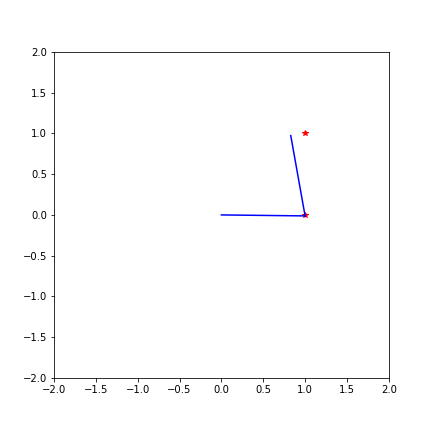

In [21]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = (6, 6)
fig, ax = plt.subplots()
ax.set_xlim((-l1-l2, l1+l2))
ax.set_ylim((-l1-l2, l1+l2))
desire_position = ax.plot(x1d, y1d, 'r*')
desire_position = ax.plot(x2d, y2d, 'r*')
line1, = ax.plot([], [], 'b')
line2, = ax.plot([], [], 'b')
lines = [line1, line2]

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return [line1, line2]

def animate(i):
    line1.set_data([0, x1[i]], [0, y1[i]])
    line2.set_data([x1[i], x2[i]], [y1[i], y2[i]])
    return [line1, line2]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=len(x1), blit=True)

## Solve with calculating controls outside of EOM

In [34]:
def eom(t, q, u, params):
    m1 , m2, l1, l2, g = params
    q1, q2, q3, q4 = q
    u1, u2 = u

    b11 = (m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*np.cos(q2)
    b12 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b21 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b22 = m2*l2**2
    B = np.array([[b11, b12], [b21, b22]])

    c1 = -m2*l1*l2*np.sin(q2)*(2*q3*q4 + q4**2)
    c2 = -m2*l1*l2*np.sin(q2)*q3*q4
    C = np.array([[c1], [c2]])
    
    g1 = -(m1 + m2)*g*l1*np.sin(q1) - m2*g*l2*np.sin(q1 + q2)
    g2 = -m2*g*l2*np.sin(q1 + q2)
    g = np.array([[g1], [g2]])
    
    Fhat = np.array([[u1], [u2]])
    F = np.dot(B, Fhat)
        
    qdotdot = np.dot(np.linalg.inv(B), -C - g + F)
    
    qdot = [q3, q4] + qdotdot.T[0].tolist()
        
    return qdot

In [36]:
q0 = [-np.pi/2, np.pi/2, 0., 0.]
ths = (np.pi/2, -np.pi/2)
Ts = 20

m1 = 1
m2 = 1
l1 = 1
l2 = 1
g = 9.81
params = (m1, m2, l1, l2, g)

Kp1 = 15
Kd1 = 7
Ki1 = 10
Kp2 = 15
Kd2 = 10
Ki2 = 10

def get_input(q):
    u1 = Kp1*(th1)
u0 = (0., 0.)
x_int = [ths[0]-q0[0], ths[1]-q0[0]]

r = ode(eom).set_integrator('dopri5')
r.set_initial_value(q0, 0).set_f_params(u0, params)
dt = 0.1
sol = []

while r.successful() and r.t < Ts:
    sol.append(r.integrate(r.t + dt))
    
sol = np.array(sol)

In [37]:
print(sol)

[[ -1.61986143   1.61867355  -0.98189403   0.93466774]
 [ -1.76785526   1.74946812  -1.98644342   1.62610402]
 [ -2.02033811   1.93135344  -3.08646446   1.94400945]
 [ -2.39023139   2.12415966  -4.33134117   1.83929826]
 [ -2.8859409    2.28464346  -5.54226399   1.30055206]
 [ -3.48019272   2.37231846  -6.19870887   0.40887588]
 [ -4.09056602   2.36216711  -5.82483865  -0.60825716]
 [ -4.61378328   2.25561779  -4.52652572  -1.48393729]
 [ -4.98364129   2.07329462  -2.85576537  -2.13011516]
 [ -5.18781114   1.83298369  -1.25834139  -2.67849038]
 [ -5.24130824   1.5318041    0.16912914  -3.40957939]
 [ -5.15189229   1.12439639   1.68295321  -4.99445581]
 [ -4.86078364   0.40803692   4.64727272 -10.64046049]
 [ -4.33478434  -0.73211205   4.34501673  -8.34224555]
 [ -3.94733004  -1.33888999   3.76450418  -4.53164722]
 [ -3.54641807  -1.70179654   4.3318714   -2.84401618]
 [ -3.07765093  -1.91763849   5.00213852  -1.48898584]
 [ -2.56449819  -2.00160628   5.12869582  -0.20384318]
 [ -2.0807